In [2]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('input_data/binary_global_BT00011.csv')

markers = ["PD1", "MHCII", "CD206", "CD45", "CD11C", "LY6G", "GRZB", "FOXP3", "CC3", 
           "CD8", "CD11B", "CD3", "LY6B2", "F480", "ASMA", "KI67", "PANCK"]

X = df[markers].values

obs = df[["sample_ID", "short_ID", "ObjectNumber", "class", "Tumor_ID", "Treatment", "slide", 
          "ROI_factor_per_tumor", "tum_factor_per_treatment"]].copy()

# Plug in Global coordinates for spatial information
spatial = df[["global_location_X", "global_location_Y"]].values

adata = ad.AnnData(X=X, obs=obs)

adata.var = pd.DataFrame(index=markers)
adata.var["marker"] = markers

adata.obsm["spatial"] = spatial

In [ ]:
adata.write("anndata/binary_global_BT00011.h5ad")

In [3]:
adata = sc.read('anndata/binary_global_BT00011.h5ad')

In [4]:
print (adata)

AnnData object with n_obs × n_vars = 153143 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    obsm: 'spatial'


In [5]:
sq.gr.spatial_neighbors(adata)
cc.gr.remove_long_links(adata)

In [6]:
print(adata)

AnnData object with n_obs × n_vars = 153143 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


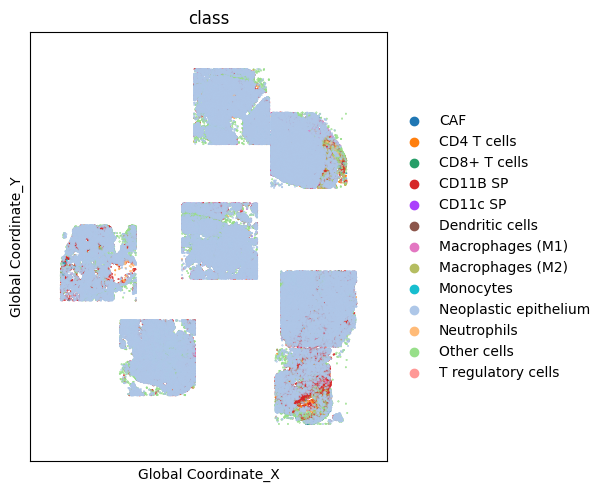

In [7]:
sq.pl.spatial_scatter(
    adata, 
    color='class', 
    shape=None,
    size=0.3,
    connectivity_key='spatial_connectivities',
    edges_width= 0.2
    )
plt.xlabel("Global Coordinate_X") 
plt.ylabel("Global Coordinate_Y") 
plt.savefig("BT00011_remove_long_conn.png", dpi=300, bbox_inches='tight')

In [8]:
#for next function, the use_rep default is adata.X, but we want to use annotated celltypes. for the algothrim the use_rep has to be numerical and embedded in obsm. so here is that conversion. 
import pandas as pd
one_hot = pd.get_dummies(adata.obs['class'])
adata.obsm['class_onehot'] = one_hot.values

In [9]:
print (adata)

AnnData object with n_obs × n_vars = 153143 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    uns: 'spatial_neighbors', 'class_colors'
    obsm: 'spatial', 'class_onehot'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [10]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='class_onehot')

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.47it/s]


In [11]:
print (adata)

AnnData object with n_obs × n_vars = 153143 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    uns: 'spatial_neighbors', 'class_colors'
    obsm: 'spatial', 'class_onehot', 'X_cellcharter'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [12]:
gmm = cc.tl.Cluster(n_clusters=5, random_state=12345)

In [13]:
gmm.fit(adata, use_rep='X_cellcharter')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 11: 100%|████████████████████████| 1/1 [00:00<00:00,  8.56it/s, nll=-194.]


In [14]:
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 15.99it/s]


In [15]:
print (adata)

AnnData object with n_obs × n_vars = 153143 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment', 'spatial_cluster'
    var: 'marker'
    uns: 'spatial_neighbors', 'class_colors', '_cellcharter'
    obsm: 'spatial', 'class_onehot', 'X_cellcharter'
    obsp: 'spatial_connectivities', 'spatial_distances'


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


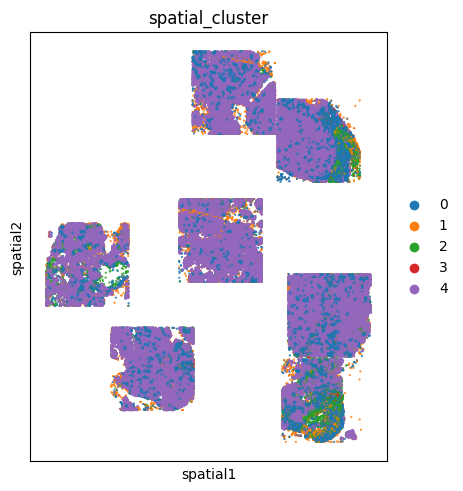

In [16]:
sq.pl.spatial_scatter(adata, shape=None, size=0.4, color="spatial_cluster")

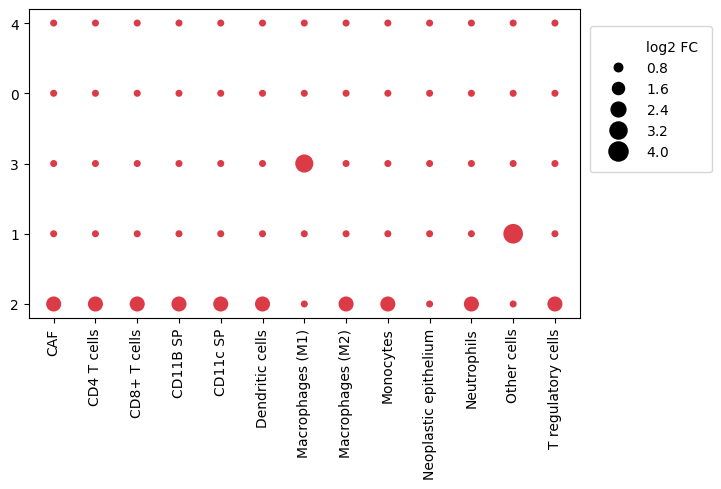

In [19]:
cc.gr.enrichment(adata, group_key='spatial_cluster', label_key='class')
cc.pl.enrichment(adata, group_key='spatial_cluster', label_key='class', figsize=(6,5), fontsize=10, dot_scale=2)

In [20]:
# Count occurrences for barplot
cluster_counts = adata.obs['spatial_cluster'].value_counts
cluster_prop = adata.obs['spatial_cluster'].value_counts(normalize=True)

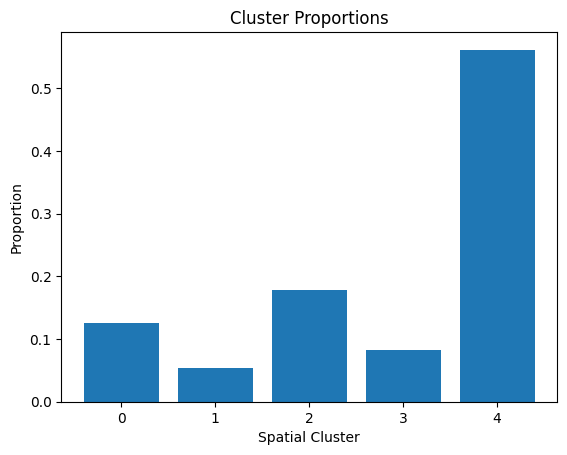

In [25]:
plt.bar(cluster_prop.index.astype(int), cluster_prop.values)
plt.xlabel('Spatial Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Proportions')
plt.show()

In [26]:
# Extract specific columns from obs
extracted_data = adata.obs[['class', 'short_ID', 'Tumor_ID', 'spatial_cluster']]
extracted_data.to_csv("new.csv", index=False) 

In [28]:
print (extracted_data)

                        class               short_ID Tumor_ID spatial_cluster
0                         CAF  Control_BT00011_ROI_1  BT00011               2
1                         CAF  Control_BT00011_ROI_1  BT00011               2
2                         CAF  Control_BT00011_ROI_1  BT00011               2
3                         CAF  Control_BT00011_ROI_1  BT00011               2
4                         CAF  Control_BT00011_ROI_1  BT00011               2
...                       ...                    ...      ...             ...
153138  Neoplastic epithelium  Control_BT00011_ROI_7  BT00011               4
153139  Neoplastic epithelium  Control_BT00011_ROI_7  BT00011               4
153140  Neoplastic epithelium  Control_BT00011_ROI_7  BT00011               0
153141  Neoplastic epithelium  Control_BT00011_ROI_7  BT00011               4
153142  Neoplastic epithelium  Control_BT00011_ROI_7  BT00011               4

[153143 rows x 4 columns]


In [29]:
agg_data = extracted_data.groupby(["spatial_cluster", "class"]).size().unstack(fill_value=0)

/var/folders/y0/xtkgj_xx1n3fylstssq873p1r3q_9y/T/ipykernel_1851/4009958697.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = extracted_data.groupby(["spatial_cluster", "class"]).size().unstack(fill_value=0)


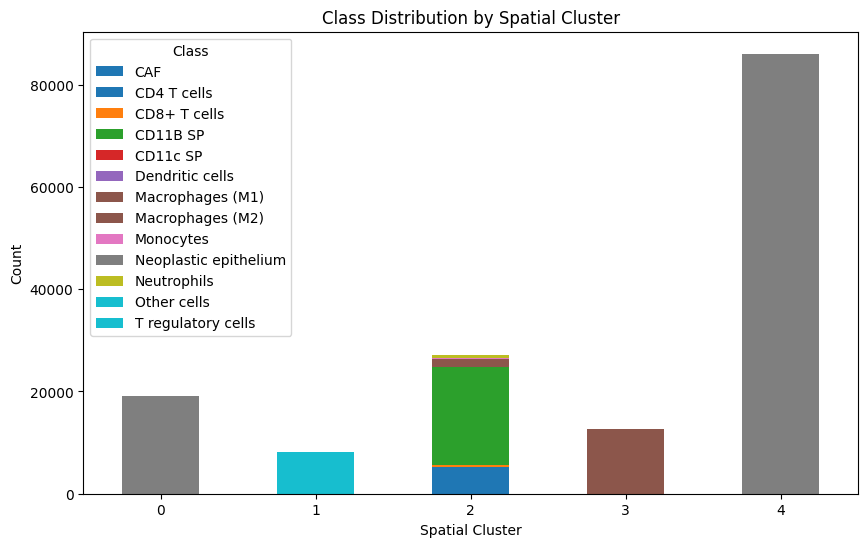

In [33]:
agg_data.plot(kind="bar", stacked=True, colormap="tab10", figsize=(10,6))
plt.title("Class Distribution by Spatial Cluster")
plt.xlabel("Spatial Cluster")
plt.ylabel("Count")
plt.xticks(rotation=0, ha="center")
plt.legend(title="Class")
plt.show()

In [ ]:
# it looks like cluster 0 and cluster 4 are tumor cells.
# most immnue cell types are pushed into 1 group. 
# is this artificial??? one spatial region should contain tumor cells and all cells in the region. 

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Text(0, 0.5, 'Global Coordinate_Y')

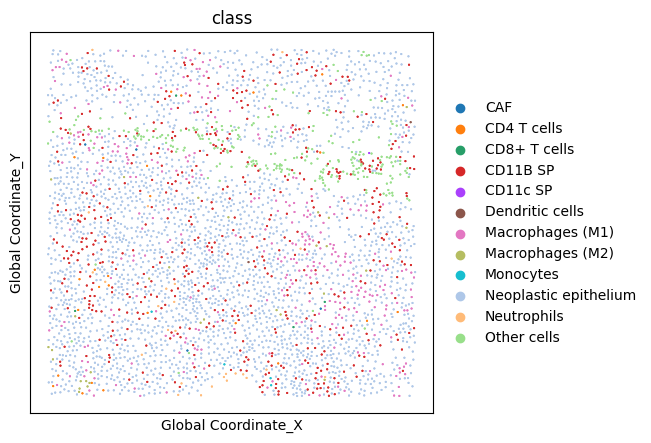

In [41]:
sq.pl.spatial_scatter(
    adata, 
    color='class', 
    shape=None,
    size=1,
    crop_coord=(10000, 1500,11500, 3500 ),
    edges_width= 0.2
    )
plt.xlabel("Global Coordinate_X") 
plt.ylabel("Global Coordinate_Y") 

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Text(0, 0.5, 'Global Coordinate_Y')

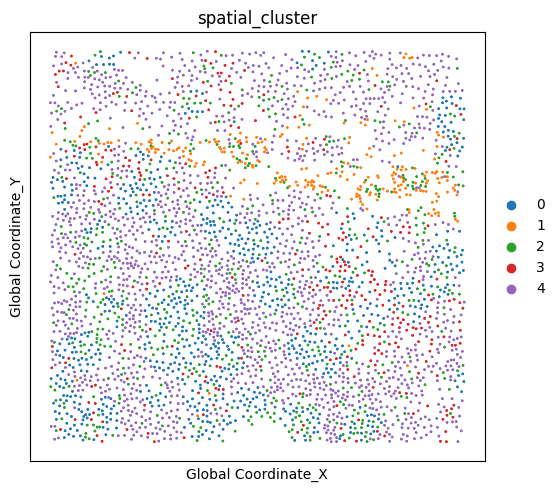

In [45]:
sq.pl.spatial_scatter(
    adata, 
    color='spatial_cluster', 
    shape=None,
    size=3,
    crop_coord=(10000, 1500,11500, 3500 ),
    edges_width= 0.2
    )
plt.xlabel("Global Coordinate_X") 
plt.ylabel("Global Coordinate_Y") 

In [ ]:
# i do not see cells accumulate inthe same "spatial cluster". for example, cluster 3-Macrophage-rich are sporaticly everywhere. 
# no other cell types belong to the same spatial cluster --> no cell-cell communication analysis. 